In [1]:
!pip -qq install transformers datasets sentence-transformers flair sklearn umap-learn

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 290 kB 38.7 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 322 kB 43.4 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 36.8 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 3.3 MB 32.9 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 132 kB 41.5 MB/s 
     |████████████████████████████████| 243 kB 31.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.6 MB/s 
     |████████████████████████████████| 1.2 MB 28.4 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 34.9 MB/s 
     |████████████████████████████████| 981 kB 39.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ..

# Evaluating Metrics

Hugging Face library not only provides dataset, but also metrics associated with those datasets. For semantic textual similarity, the two common datasets included in GLUE are MRPC and STSB. For the former, the accuracy is calculated. For the latter, the Pearson correlation coefficient and Spearman rank correlation coefficient are calculated.

In [ ]:
from datasets import load_metric, load_dataset 
metric = load_metric('glue', 'mrpc') 
metric.compute(predictions=[1,0,0],references=[0,0,1]) 

{'accuracy': 0.3333333333333333, 'f1': 0.0}

In [ ]:
from datasets import load_metric, load_dataset 
metric = load_metric('glue', 'stsb') 
metric.compute(predictions=[1,2,3],references=[5,2,2]) 

{'pearson': -0.8660254037844388, 'spearmanr': -0.8660254037844387}

# Benchmarking sentence similarity models

In [ ]:
#!pip install sentence-transformers

In [ ]:
from datasets import load_metric, load_dataset 
stsb = load_dataset('glue', 'stsb') 
stsb_metric = load_metric('glue', 'stsb') 

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer 
distilroberta = SentenceTransformer('stsb-distilroberta-base-v2') 

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/680 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Unfortunately,TTBOMK, Universal Sentence Encoder is not avaialable in PyTorch 
import tensorflow_hub as hub 
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [ ]:
import tensorflow as tf 
import math 
def use_sts_benchmark(batch): 
    sts_encode1 = tf.nn.l2_normalize(use_model(tf.constant(batch['sentence1'])),axis=1) 
    sts_encode2 = tf.nn.l2_normalize(use_model(tf.constant(batch['sentence2'])),axis=1) 
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1,sts_encode2),axis=1) 
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities,-1.0,1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi 
    return scores 

In [ ]:
def roberta_sts_benchmark(batch): 
    sts_encode1 = tf.nn.l2_normalize(distilroberta.encode(batch['sentence1']),axis=1) 
    sts_encode2 = tf.nn.l2_normalize(distilroberta.encode(batch['sentence2']),axis=1) 
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1,sts_encode2),axis=1) 
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities,-1.0,1.0) 
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi 
    return scores 

In [ ]:
use_results = use_sts_benchmark(stsb['validation']) 
distilroberta_results = roberta_sts_benchmark(stsb['validation']) 

In [ ]:
references = [item['label'] for item in stsb['validation']]

In [ ]:
results = { 
      "USE":stsb_metric.compute( 
                predictions=use_results, 
                references=references), 
      "DistillRoberta":stsb_metric.compute( 
                predictions=distilroberta_results, 
                references=references) 
} 

In [ ]:
import pandas as pd 
pd.DataFrame(results) 

,USE,DistillRoberta
pearson,0.810301,0.888461
spearmanr,0.808917,0.889247


# Using BART for zero-shot learning

## Using Pipeline API

In [ ]:
from transformers import pipeline 
import pandas as pd
bart_model = '../../models/facebook-bart-large-mnli/'
classifier = pipeline("zero-shot-classification", 
                      model=bart_model) 
sequence_to_classify = "one day I will see the world" 
candidate_labels = ['travel', 
                    'cooking', 
                    'dancing', 
                    'exploration'] 
result = classifier(sequence_to_classify, candidate_labels) 
pd.DataFrame(result)

,sequence,labels,scores
0,one day I will see the world,travel,0.795756
1,one day I will see the world,exploration,0.199332
2,one day I will see the world,dancing,0.002621
3,one day I will see the world,cooking,0.002291


The results above are normalized to 1. For multi-label, they won't be normalized since the sequence can belong to multiple classes at the same time.

In [ ]:
result = classifier(sequence_to_classify,  
                      candidate_labels,  
                      multi_label=True) 
pd.DataFrame(result) 

,sequence,labels,scores
0,one day I will see the world,travel,0.994511
1,one day I will see the world,exploration,0.938389
2,one day I will see the world,dancing,0.005706
3,one day I will see the world,cooking,0.001819


## Without Pipeline API

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 

nli_model = AutoModelForSequenceClassification.from_pretrained(bart_model) 
tokenizer = AutoTokenizer.from_pretrained(bart_model) 

In [ ]:
premise = "one day I will see the world" 
label = "travel" 
hypothesis = f'This example is {label}.' 

In [ ]:
x = tokenizer.encode( 
    premise, 
    hypothesis, 
    return_tensors='pt', 
    truncation='only_first') 

In [ ]:
logits = nli_model(x)[0] 
entail_contradiction_logits = logits[:,[0,2]] 
probs = entail_contradiction_logits.softmax(dim=1) 
prob_label_is_true = probs[:,1] 
print(prob_label_is_true) 

tensor([0.9945], grad_fn=<SelectBackward>)


# Semantic similarity experiment with FLAIR

In [ ]:
!pip install flair

## Custom Mini-Dataset for Similar and Dissimilar Sentences (taken from STSB)

In [2]:
import pandas as pd
similar=[("A black dog walking beside a pool.","A black dog is walking along the side of a pool."),
("A blonde woman looks for medical supplies for work in a suitcase.	"," The blond woman is searching for medical supplies in a suitcase."),
("A doubly decker red bus driving down the road.","A red double decker bus driving down a street."),
("There is a black dog jumping into a swimming pool.","A black dog is leaping into a swimming pool."),
("The man used a sword to slice a plastic bottle.","A man sliced a plastic bottle with a sword.")]
pd.DataFrame(similar, columns=["sen1", "sen2"])

,sen1,sen2
0,A black dog walking beside a pool.,A black dog is walking along the side of a pool.
1,A blonde woman looks for medical supplies for ...,The blond woman is searching for medical supp...
2,A doubly decker red bus driving down the road.,A red double decker bus driving down a street.
3,There is a black dog jumping into a swimming p...,A black dog is leaping into a swimming pool.
4,The man used a sword to slice a plastic bottle.,A man sliced a plastic bottle with a sword.


In [3]:
import pandas as pd
dissimilar= [("A little girl and boy are reading books. ", "An older child is playing with a doll while gazing out the window."),
("Two horses standing in a field with trees in the background.", "A black and white bird on a body of water with grass in the background."),
("Two people are walking by the ocean." , "Two men in fleeces and hats looking at the camera."),
("A cat is pouncing on a trampoline.","A man is slicing a tomato."),
("A woman is riding on a horse.","A man is turning over tables in anger.")]
pd.DataFrame(dissimilar, columns=["sen1", "sen2"])

,sen1,sen2
0,A little girl and boy are reading books.,An older child is playing with a doll while ga...
1,Two horses standing in a field with trees in t...,A black and white bird on a body of water with...
2,Two people are walking by the ocean.,Two men in fleeces and hats looking at the cam...
3,A cat is pouncing on a trampoline.,A man is slicing a tomato.
4,A woman is riding on a horse.,A man is turning over tables in anger.


## Cosine Similarity

In [4]:
import torch, numpy as np
def sim(s1,s2):
    # cosine similarity function outputs in the range 0-1
    s1=s1.embedding.unsqueeze(0)
    s2=s2.embedding.unsqueeze(0)
    sim=torch.cosine_similarity(s1,s2).item() 
    return np.round(sim,2)

## Evaluating Pairs

In [5]:
from flair.data import Sentence
def evaluate(embeddings, myPairList):
    # it evaluates embeddings for a given list of sentence pair
    scores=[]
    for s1, s2 in myPairList:
        s1,s2=Sentence(s1), Sentence(s2)
        embeddings.embed(s1)
        embeddings.embed(s2)
        score=sim(s1,s2)
        scores.append(score)
    return scores, np.round(np.mean(scores),2)

## Different Types of Embeddings

### Document Pool (Average Word) Embeddings

In [6]:
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings
glove_embedding = WordEmbeddings('glove')
glove_pool_embeddings = DocumentPoolEmbeddings([glove_embedding])

2021-11-22 12:41:24,066 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpyndekoxa


100%|██████████| 160000128/160000128 [00:07<00:00, 20104224.81B/s]

2021-11-22 12:41:32,407 copying /tmp/tmpyndekoxa to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2021-11-22 12:41:32,753 removing temp file /tmp/tmpyndekoxa
2021-11-22 12:41:33,327 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpulcltdng


100%|██████████| 21494764/21494764 [00:02<00:00, 7486597.38B/s] 

2021-11-22 12:41:36,577 copying /tmp/tmpulcltdng to cache at /root/.flair/embeddings/glove.gensim


2021-11-22 12:41:36,627 removing temp file /tmp/tmpulcltdng


In [7]:
evaluate(glove_pool_embeddings, similar)

([0.97, 0.99, 0.97, 0.99, 0.98], 0.98)

In [8]:
evaluate(glove_pool_embeddings, dissimilar)

([0.94, 0.97, 0.94, 0.92, 0.93], 0.94)

:-( Not the result we expected. They should have been < 0.4.

### RNN-based Document Embeddings

In [9]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings
gru_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [10]:
evaluate(gru_embeddings, similar)

([0.99, 1.0, 0.97, 1.0, 0.92], 0.98)

In [11]:
evaluate(gru_embeddings, dissimilar)

([0.92, 1.0, 0.95, 0.86, 0.93], 0.93)

### Transformer-based BERT Embeddings

In [12]:
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
bert_embeddings = TransformerDocumentEmbeddings('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [13]:
evaluate(bert_embeddings, similar)

([0.85, 0.9, 0.96, 0.91, 0.89], 0.9)

In [14]:
evaluate(bert_embeddings, dissimilar)

([0.93, 0.94, 0.86, 0.93, 0.92], 0.92)

### Sentence-BERT embeddings

In [15]:
from flair.data import Sentence
from flair.embeddings import SentenceTransformerDocumentEmbeddings
# init embedding
sbert_embeddings = SentenceTransformerDocumentEmbeddings('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
evaluate(sbert_embeddings, similar)

([0.98, 0.95, 0.96, 0.99, 0.98], 0.97)

In [17]:
evaluate(sbert_embeddings, dissimilar)

([0.48, 0.41, 0.19, -0.05, 0.0], 0.21)

Much better! Let's test tricky samples.

In [18]:
tricky_pairs=[("An elephant is bigger than a lion",
               "A lion is bigger than an elephant") ,
              ("the cat sat on the mat",
               "the mat sat on the cat")]

In [19]:
evaluate(glove_pool_embeddings, tricky_pairs)

([1.0, 1.0], 1.0)

In [20]:
evaluate(gru_embeddings, tricky_pairs)

([0.93, 0.74], 0.84)

In [21]:
evaluate(bert_embeddings, tricky_pairs)

([1.0, 0.98], 0.99)

In [22]:
evaluate(sbert_embeddings, tricky_pairs)

([0.93, 0.97], 0.95)

Even the SBERT fails here since it is intended for content similarity and topic detection and not meaning!

## Classification using Transformers Library

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
nli_model = AutoModelForSequenceClassification.from_pretrained('joeddav/xlm-roberta-large-xnli')
tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [26]:
import numpy as np
for premise, hypothesis in tricky_pairs:
    x = tokenizer.encode( 
        premise, 
        hypothesis, 
        return_tensors='pt', 
        truncation='only_first') 
    logits = nli_model(x)[0]
    print(f"Permise: {permise}")
    print(f"Hypothesis: {hypothesis}")
    print("Top Class:")
    print(nli_model.config.id2label[np.argmax(logits[0].detach().numpy())])
    print("Full softmax scores:")
    for i in range(3):
        print(nli_model.config.id2label[i],logits.softmax(dim=1)[0][i].detach().numpy())
    print("="*20)

Permise: An elephant is bigger than a lion
Hypothesis: A lion is bigger than an elephant
Top Class:
contradiction
Full softmax scores:
contradiction 0.9954543
neutral 0.00049089483
entailment 0.004054804
Permise: An elephant is bigger than a lion
Hypothesis: the mat sat on the cat
Top Class:
entailment
Full softmax scores:
contradiction 0.49365422
neutral 0.007260747
entailment 0.499085


# Text clustering with Sentence-BERT

## Dataset

We will use the Amazaon Polarity Dataset that includes Amazon web page reviews spanning a period of 18 years up to March 2013. The original dataset includes over 35 million reviews.

In [27]:
import pandas as pd, numpy as np
import torch, os
from datasets import load_dataset
dataset = load_dataset("amazon_polarity",split="train")
dataset

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/ac31acedf6cda6bc2aa50d448f48bbad69a3dd8efc607d2ff1a9e65c2476b4c1. Subsequent calls will reuse this data.


Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})

We will randomly select 10K samples

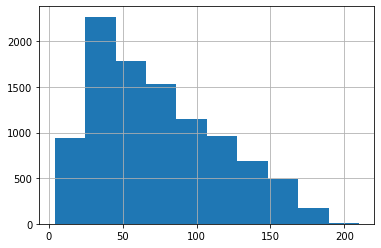

In [28]:
corpus=dataset.shuffle(seed=42)[:10000]['content']
pd.Series([len(e.split()) for e in corpus]).hist()

## Model

In [29]:
from sentence_transformers import SentenceTransformer
model_path="paraphrase-distilroberta-base-v1"
#paraphrase-distilroberta-base-v1 - Trained on large scale paraphrase data.
model = SentenceTransformer(model_path)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Mapping List of Sentences to Embedding Vectors

In [30]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(10000, 768)

## Clustering using KMeans

In [31]:
from sklearn.cluster import KMeans
K=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(corpus_embeddings)

In [32]:
import pandas as pd
cls_dist=pd.Series(kmeans.labels_).value_counts()
cls_dist

0    2759
3    2155
4    1890
1    1849
2    1347
dtype: int64

## Finding the topic of Each Cluster

To find the topic of each cluster, we will first locate the centroid of the vectors (which is an imaginary vector). Then we will find a real data point that is closest to the centroid. We can then manually read the vector and assign the cluster a topic.

In [33]:
import scipy
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_ , corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		2759		1761		I read this book a while back and thought it was very interesting. It's a good book to read if your tired of just reading love stories all the time.
1		1849		9447		I ordered the product I see on the screen but what I got was a white bottle of some other type of shampoo... it was NOT just the packaging.How can someone be loyal to a product if they keep changing the formulas!? You will never keep everyone happy.I was disappointed that after 2 calls no correction was ever sent. VERY disappointed.
2		1347		3900		This album like many rock/emo albums is good, but there is nothing innovative about it, some very catchy tunes, good singing, nice rhythm. Awesome to listen to. Worth the buy.
3		2155		1474		The quality of this product is great, easy to clean and fits my sink perfectly.However, I think it is a little bit expensive.
4		1890		204		This DVD looks nice and all but is horrible because it skips and stuff after the first time I watc

It seems to be that the Kmeans clusters the reviews into five distinct categories: Electronics, Audio Cd/
Music, DVD Film, Books, and Furniture & Home.

## Dimensionality Reduction

We will use the Uniform Manifold Approximation and Projection (UMAP) library to reduce dimensionality. Other
widely used dimensionality reduction techniques in NLP that you can use include t-SNE and PCA

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


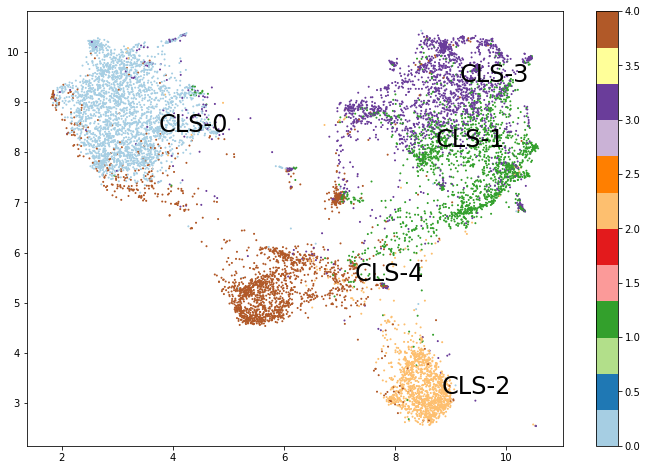

In [34]:
import matplotlib.pyplot as plt
import umap
X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1], "CLS-"+ str(c), fontsize=24) 
plt.colorbar()

# Semantic search with Sentence-BERT

In [35]:
import pandas as pd
import sklearn
import numpy as np

We use FAQ from the World Wide Fund for Nature (WWF)

In [36]:
wwf_faq=["I haven’t received my adoption pack. What should I do?",
         "How quickly will I receive my adoption pack?",
         "How can I renew my adoption?",
         "How do I change my address or other contact details?",
         "Can I adopt an animal if I don’t live in the UK?",
         "If I adopt an animal, will I be the only person who adopts that animal?",
         "My pack doesn't contain a certicate",
         "My adoption is a gift but won’t arrive on time. What can I do?",
         "Can I pay for an adoption with a one-off payment?",
         "Can I change the delivery address for my adoption pack after I’ve placed my order?",
         "How long will my adoption last for?",
         "How often will I receive updates about my adopted animal?",
         "What animals do you have for adoption?",
         "How can I nd out more information about my adopted animal?",
         "How is my adoption money spent?",
         "What is your refund policy?",
         "An error has been made with my Direct Debit payment, can I receive a refund?",
         "How do I change how you contact me?"]

In [37]:
from sentence_transformers import SentenceTransformer
# This is fine-tuned for Quora Duplicate Questions detection retrieval.
model = SentenceTransformer("quora-distilbert-base") 

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/490 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
faq_embeddings = model.encode(wwf_faq)

In [39]:
test_questions=["What should be done, if the adoption pack did not reach to me?",
                " How fast is my adoption pack delivered to me?",
                "What should I do to renew my adoption?",
                "What should be done to change adress and contact details ?",
                "I live outside of the UK, Can I still adopt an animal?"]
test_q_emb= model.encode(test_questions)

Note that the five questions are similar to the first five FAQs

The following code measures the similarity between each test question and each question in the FAQ and then ranks them

In [40]:
from scipy.spatial.distance import cdist
for q, qe in zip(test_questions, test_q_emb):
    distances = cdist([qe], faq_embeddings, "cosine")[0]
    ind = np.argsort(distances, axis=0)[:3]
    print("\n Test Question: \n "+q)
    for i,(dis,text) in enumerate(zip(distances[ind], [wwf_faq[i] for i in ind])):
        print(dis,ind[i],text, sep="\t")


 Test Question: 
 What should be done, if the adoption pack did not reach to me?
0.1494579732775143	0	I haven’t received my adoption pack. What should I do?
0.24940233781117593	7	My adoption is a gift but won’t arrive on time. What can I do?
0.36697608707019747	1	How quickly will I receive my adoption pack?

 Test Question: 
  How fast is my adoption pack delivered to me?
0.1658239219866281	1	How quickly will I receive my adoption pack?
0.3470481394177929	0	I haven’t received my adoption pack. What should I do?
0.35111139734557173	7	My adoption is a gift but won’t arrive on time. What can I do?

 Test Question: 
 What should I do to renew my adoption?
0.04168251677243584	2	How can I renew my adoption?
0.2993020109073601	12	What animals do you have for adoption?
0.30140741524859604	0	I haven’t received my adoption pack. What should I do?

 Test Question: 
 What should be done to change adress and contact details ?
0.27660179239091964	3	How do I change my address or other contact detail

Here, we can see indexes 0 , 1 , 2 , 3 , and 4 in order, which means the model successfully found the similar questions as expected.

The following function takes a question and returns K most similar questions in the FAQ

In [41]:
def get_best(query, K=3):
    query_embedding = model.encode([query])
    distances = cdist(query_embedding, faq_embeddings, "cosine")[0]
    ind = np.argsort(distances, axis=0)
    print("\n"+query)
    for c,i in list(zip(distances[ind],  ind))[:K]:
        print(c,wwf_faq[i], sep="\t")

In [42]:
get_best("How do I change my contact info?",3)


How do I change my contact info?
0.05676792675570708	How do I change my address or other contact details?
0.18566537321072885	How do I change how you contact me?
0.3240832721600133	How can I renew my adoption?


In [43]:
get_best("How do I get my plane ticket if I bought it online?")


How do I get my plane ticket if I bought it online?
0.35947514060530594	How do I change how you contact me?
0.36807870611610016	How do I change my address or other contact details?
0.43066360868975995	My adoption is a gift but won’t arrive on time. What can I do?


We can define a threshold such as 0.3 so that the model ignores such questions that are higher than that threshold and says 'no similar answer found'.